In [3]:
import os
import numpy as np
import librosa
import time
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Utility Function to Pad Audio
def pad_audio(audio, max_length):
    pad_size = max_length - len(audio)
    if pad_size > 0:
        audio = np.pad(audio, (0, pad_size), 'constant')
    return audio

# Load and Pad Audio
def load_and_pad_audio(file_paths, max_length):
    audio_list = []
    for file_path in file_paths:
        try:
            audio, _ = librosa.load(file_path, sr= None, res_type='soxr_lq')
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
        audio = pad_audio(audio, max_length)
        audio_list.append(audio)
    return np.array(audio_list)

# Data Generator
def data_generator(file_paths, max_length, batch_size):
    while True:
        batch_paths = np.random.choice(a=file_paths, size=batch_size)
        batch_audio = load_and_pad_audio(batch_paths, max_length)
        yield batch_audio, batch_audio

# Directorios
try:
    clean_directory = '/Users/marcgrayson/Procesamiento de Datos/direction_commands.extracted.tar'
    noisy_directory = '/Users/marcgrayson/Procesamiento de Datos/direction_commands_with_noise'
except Exception as e:
    print(f"Error loading directories: {e}")

# Cargar datos
clean_data, noisy_data = {}, {}
for dirpath, _, filenames in os.walk(clean_directory):
    label = os.path.basename(dirpath)
    if label and label != os.path.basename(clean_directory):
        clean_data[label] = [os.path.join(dirpath, f) for f in filenames if f.endswith('.wav')]

for dirpath, _, filenames in os.walk(noisy_directory):
    label = os.path.basename(dirpath)
    if label and label != os.path.basename(noisy_directory):
        noisy_data[label] = [os.path.join(dirpath, f) for f in filenames if f.startswith('noisy_') and f.endswith('.wav')]

# Dataset Split
train_ratio, val_ratio = 0.7, 0.2
train_data, val_data = {}, {}
for label in clean_data.keys():
    clean_paths = clean_data[label]
    random.shuffle(clean_paths)
    n = len(clean_paths)
    train_count = int(train_ratio * n)
    train_data[label] = clean_paths[:train_count]
    val_data[label] = clean_paths[train_count:]

# Preprocessing usando Data Generator
batch_size = 32
max_length = 16000  # 1 second
train_gen = data_generator([f for sublist in train_data.values() for f in sublist], max_length, batch_size)
val_gen = data_generator([f for sublist in val_data.values() for f in sublist], max_length, batch_size)

# Definición Modelo
input_audio = Input(shape=(16000, 1))
encoded = Conv1D(64, 3, activation='relu', padding='same')(input_audio)
encoded = MaxPooling1D(2, padding='same')(encoded)
decoded = Conv1D(64, 3, activation='relu', padding='same')(encoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(decoded)
autoencoder = Model(input_audio, decoded)

# Training
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
steps_per_epoch = len([f for sublist in train_data.values() for f in sublist]) // batch_size
validation_steps = len([f for sublist in val_data.values() for f in sublist]) // batch_size

history = autoencoder.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=10,
    batch_size=batch_size
)


Epoch 1/10
206/206 [==============================] - 102s 496ms/step - loss: 0.0326 - val_loss: 0.0038
Epoch 2/10
206/206 [==============================] - 103s 499ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 3/10
206/206 [==============================] - 110s 536ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 4/10
206/206 [==============================] - 69s 336ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/10
206/206 [==============================] - 64s 311ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 6/10
206/206 [==============================] - 58s 282ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 7/10
206/206 [==============================] - 60s 291ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/10
206/206 [==============================] - 65s 314ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 9/10
206/206 [==============================] - 65s 316ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 10/10
206/206 [==============================] - 63s 304ms/step 

In [5]:
# Extraer la pérdida de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

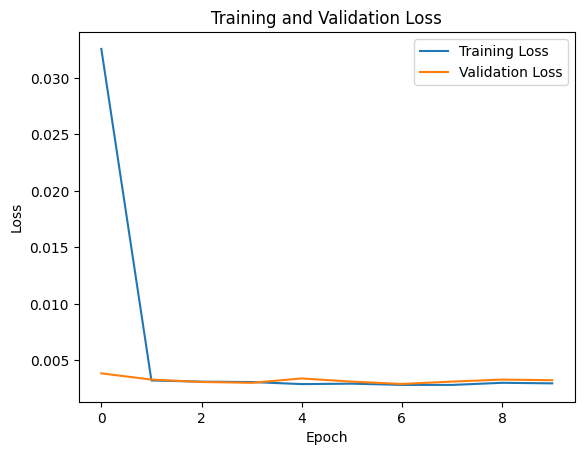

In [6]:
import matplotlib.pyplot as plt

# Plot de entrenamiento y validación
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_psnr(true, pred):
    mse = mean_squared_error(true.flatten(), pred.flatten())
    max_pixel = 1.0  # as the audio is normalized
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Calcular el PSNR
psnr_value = calculate_psnr(X_val_batch, predictions)
print(f"PSNR Value: {psnr_value}")


PSNR Value: 21.922395280134815


In [17]:
#2do método
# Eliminar la dimensión extra
predictions_squeezed = np.squeeze(predictions, axis=-1)

# Calcular el PSNR
psnr_value = calculate_psnr(X_val_batch, predictions_squeezed)
print(f"PSNR Value: {psnr_value}")


PSNR Value: 21.922395280134815


In [11]:
autoencoder.save("encoder_model")


INFO:tensorflow:Assets written to: encoder_model/assets


INFO:tensorflow:Assets written to: encoder_model/assets


1/1 [==============================] - 0s 53ms/step
PSNR Value: 23.67917260708932
Audio original con ruido:


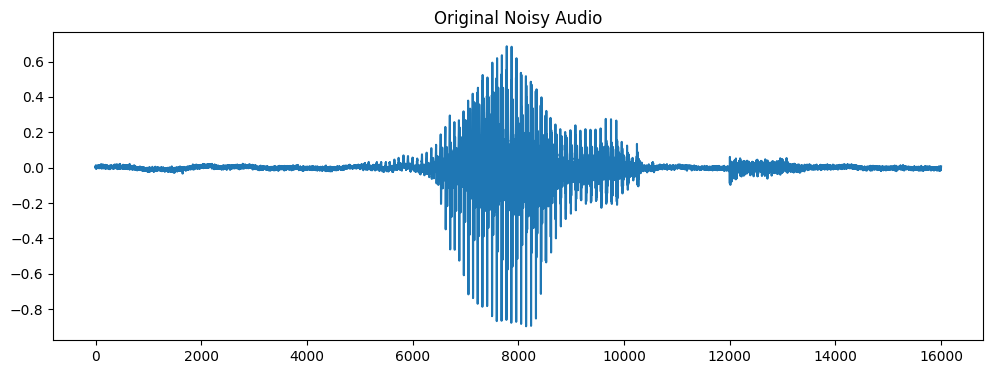

Audio después del denoising:


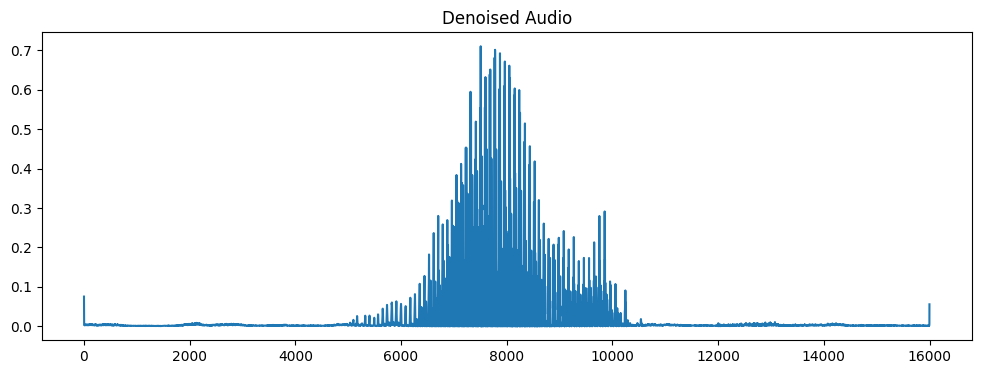

In [16]:
from IPython.display import Audio, display
from sklearn.metrics import mean_squared_error

# Función para calcular el PSNR
def calculate_psnr(true, pred):
    mse = mean_squared_error(true.flatten(), pred.flatten())
    max_pixel = 1.0  # as the audio is normalized
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Ruta al archivo de audio para prueba
test_file_path = '/Users/marcgrayson/Procesamiento de Datos/direction_commands_with_noise/right/noisy_0b40aa8e_nohash_0.wav'

# Cargar y preprocesar el archivo de audio
test_audio, sr = librosa.load(test_file_path, sr=None, res_type='soxr_lq')
test_audio_padded = pad_audio(test_audio, max_length=16000)

# Realizar la predicción con el modelo
test_audio_predict = autoencoder.predict(test_audio_padded.reshape(1, -1, 1))

# Postprocesamiento
denoised_test_audio = np.squeeze(test_audio_predict, axis=(0, -1))

# Cálculo del PSNR
psnr_value = calculate_psnr(test_audio_padded, denoised_test_audio)
print(f"PSNR Value: {psnr_value}")

# Visualización y reproducción del audio
# Audio original
print("Audio original con ruido:")
plt.figure(figsize=(12, 4))
plt.plot(test_audio_padded)
plt.title("Original Noisy Audio")
plt.show()
display(Audio(test_audio_padded, rate=sr))

# Audio después del denoising /reduccion ruido
print("Audio después del denoising:")
plt.figure(figsize=(12, 4))
plt.plot(denoised_test_audio)
plt.title("Denoised Audio")
plt.show()
display(Audio(denoised_test_audio, rate=sr))
